In [151]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [118]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from skimage import io, transform
import glob
import tables


timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

In [150]:
from iterative_lda import IterativeLDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

## Load MNIST


In [120]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

In [121]:
def extract_data(mnist, first_label, second_label):
    indices = np.logical_or(mnist.target == first_label, mnist.target == second_label)
    return mnist.data[indices], mnist.target[indices]

X, y = extract_data(mnist, 4, 9)
X.shape, y.shape

((13782, 784), (13782,))

## Fit an LDA model to the entire data-set

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=RANDOM_SEED,
                                                    stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((12403, 784), (12403,), (1379, 784), (1379,))

In [123]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print(np.sum(lda.predict(X_train) == y_train) / y_train.shape[0])
print(np.sum(lda.predict(X_test) == y_test) / y_test.shape[0])

0.969442876723
0.960841189268


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [124]:
# raise ValueError('Dont run again')
ilda = IterativeLDA(5)
transformed_X_train = ilda.fit_transform(X_train, y_train)
transformed_X_test = ilda.transform(X_test)

/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [125]:
rfc = RandomForestClassifier(verbose=True)
rfc.fit(transformed_X_train, y_train)

print(np.sum(rfc.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(rfc.predict(transformed_X_test) == y_test) / y_test.shape[0])

0.994678706764


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [126]:
svm = SVC(verbose=True)
svm.fit(transformed_X_train, y_train)

print(np.sum(svm.predict(transformed_X_train) == y_train) / y_train.shape[0])
print(np.sum(svm.predict(transformed_X_test) == y_test) / y_test.shape[0])

[LibSVM]0.969765379344
0.961566352429


## Examine projections a little bit

In [138]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1, whiten=False, copy=True)
pca.fit(X_train)
pca_projections = pca.transform(X_test)
pca_reconstructions = pca.inverse_transform(pca_projections).reshape((-1, 28, 28))

pca_5 = PCA(n_components=5, whiten=False, copy=True)
pca_5.fit(X_train)
pca_projections_5 = pca_5.transform(X_test)
pca_reconstructions_5 = pca_5.inverse_transform(pca_projections_5).reshape((-1, 28, 28))

In [143]:
lda_projections = lda.transform(X_test)
lda_reconstructions = (lda_projections.dot(lda.scalings_.T) + lda.xbar_).reshape((-1, 28, 28))
# lda_reconstructions = (lda_projections.dot(lda.coef_)).reshape((-1, 28, 28))

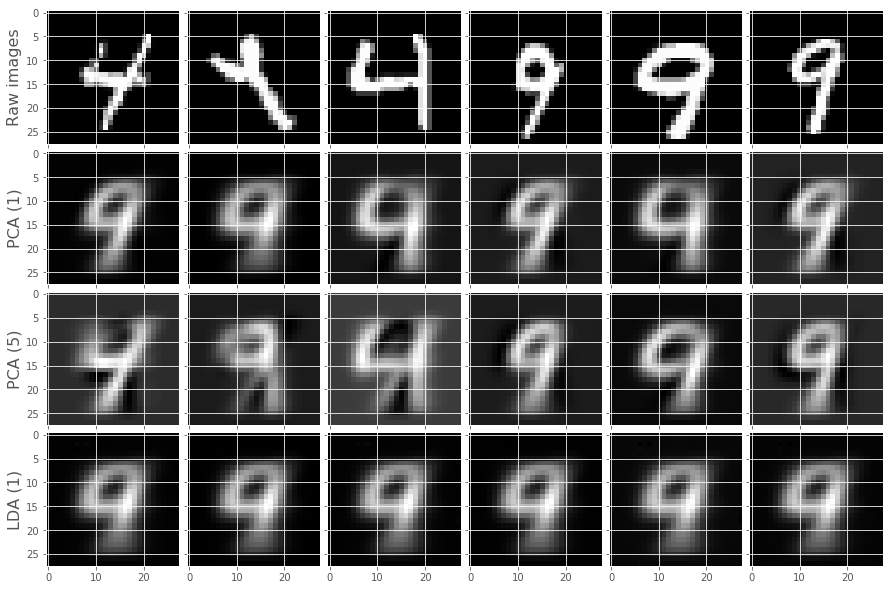

In [144]:
ROWS = 4
COLS = 6
HALF_COLS = COLS // 2
FONT_SIZE = 16

fig = plt.figure(1, (15, 25))
plt.gray()
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(ROWS, COLS),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch
                )

for i in range(0, HALF_COLS):
    grid[i].imshow(X_test[y_test == 4][i].reshape((28, 28)))
    grid[3 + i].imshow(X_test[y_test == 9][i].reshape((28, 28)))
    grid[6 + i].imshow(pca_reconstructions[y_test == 4][i])
    grid[9 + i].imshow(pca_reconstructions[y_test == 9][i])
    grid[12 + i].imshow(pca_reconstructions_5[y_test == 4][i])
    grid[15 + i].imshow(pca_reconstructions_5[y_test == 9][i])
    grid[18 + i].imshow(lda_reconstructions[y_test == 4][i])
    grid[21 + i].imshow(lda_reconstructions[y_test == 9][i])
    
    if 0 == i:
        grid[i].set_ylabel('Raw images', size=FONT_SIZE)
        grid[6 + i].set_ylabel('PCA (1)', size=FONT_SIZE)
        grid[12 + i].set_ylabel('PCA (5)', size=FONT_SIZE)
        grid[18 + i].set_ylabel('LDA (1)', size=FONT_SIZE)


plt.show()

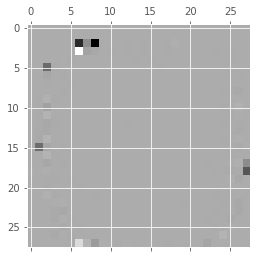

In [129]:
plt.gray()
plt.matshow(lda.coef_[0].reshape((28, 28))) 
plt.show() 

In [130]:


# ilda_projections = transformed_X_test
# ilda_coef = np.hstack(l.coef_.shape)
# ilda_reconstructions = ilda_projections.dot(ilda_coef)

In [61]:
np.dot(X_test[0] - lda.xbar_, lda.scalings_), lda_projections[0]

(array([-2.95145503]), array([-2.95145503]))

In [71]:
().shape

(1379, 784)

In [70]:
X_test.shape

(1379, 784)

In [148]:
lda.scalings_.shape, lda.coef_.shape

((784, 1), (1, 784))

In [178]:
ilda_sc = IterativeLDA(n_components=10, use_coef=False, verbose=True)
X_sc = ilda_sc.fit_transform(X_train, y_train)

Fitting component 1


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 2
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 3
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 4
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 5
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 6
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 7
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 8
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 9
Using scalings
Computing nullspace
Projecting onto nullspace
Fitting component 10
Using scalings
Computing nullspace
Projecting onto nullspace


In [179]:
ilda_c = IterativeLDA(n_components=10, use_coef=True, verbose=True)
X_c = ilda_c.fit_transform(X_train, y_train)

Fitting component 1


/Users/guydavidson/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Computing nullspace
Projecting onto nullspace
Fitting component 2
Computing nullspace
Projecting onto nullspace
Fitting component 3
Computing nullspace
Projecting onto nullspace
Fitting component 4
Computing nullspace
Projecting onto nullspace
Fitting component 5
Computing nullspace
Projecting onto nullspace
Fitting component 6
Computing nullspace
Projecting onto nullspace
Fitting component 7
Computing nullspace
Projecting onto nullspace
Fitting component 8
Computing nullspace
Projecting onto nullspace
Fitting component 9
Computing nullspace
Projecting onto nullspace
Fitting component 10
Computing nullspace
Projecting onto nullspace


In [183]:
for i in range(len(ilda_sc.nullspaces_)):
    scalings_ns = ilda_sc.nullspaces_[i]
    coef_ns = ilda_c.nullspaces_[i]
    print(i, np.allclose(scalings_ns, coef_ns))



0 True
1 True
2 True
3 True
4 False
5 False
6 False
7 False
8 False
9 False


In [184]:
for i in range(X_sc.shape[1]):
    print(i, np.allclose(X_sc[:,i], X_c[:,i]))


0 True
1 True
2 True
3 True
4 True
5 True
6 True
7 True
8 True
9 True
